### Challenge description
The Titanic, hailed as 'unsinkable,' tragically sank on April 15, 1912, after colliding with an iceberg. As a result, 1502 out of 2224 individuals perished in the biting cold. Our primary goal is straightforward: employ machine learning to develop a model capable of predicting which passengers survived the Titanic catastrophe.

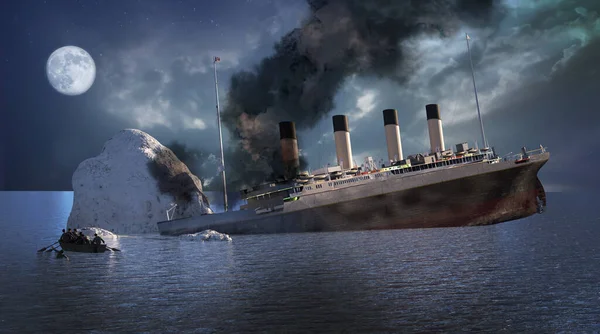

In [37]:
from IPython.display import display, Image
display(Image('titanic.jpg'))

### Import the required libraries to perform the analysis

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

### Importing the data
Source: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv

In [39]:
titanic_df = pd.read_csv('titanic.csv')
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Table explaining investigated variables

In [40]:
from tabulate import tabulate

data = [
    ['Survived', 'Survival', '0 = No, 1 = Yes'],
    ['Pclass', 'Ticket class', '1 = 1st, 2 = 2nd, 3 = 3rd'],
    ['Sex', 'Sex', ''],
    ['Age', 'Age in years', ''],
    ['SibSp', '# of siblings/spouses aboard the Titanic', ''],
    ['Parch', '# of parents/children aboard the Titanic', ''],
    ['Ticket', 'Ticket number', ''],
    ['Fare', 'Passenger fare', ''],
    ['Cabin', 'Cabin number', ''],
    ['Embarked', 'Port of Embarkation', 'C = Cherbourg, Q = Queenstown, S = Southampton']
]

col_names = ['Variable', 'Definition', 'Key']


print(tabulate(data, col_names, tablefmt='grid'))

+------------+------------------------------------------+------------------------------------------------+
| Variable   | Definition                               | Key                                            |
+============+==========================================+================================================+
| Survived   | Survival                                 | 0 = No, 1 = Yes                                |
+------------+------------------------------------------+------------------------------------------------+
| Pclass     | Ticket class                             | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
+------------+------------------------------------------+------------------------------------------------+
| Sex        | Sex                                      |                                                |
+------------+------------------------------------------+------------------------------------------------+
| Age        | Age in years          

### Data preparation and cleaning

In [41]:
titanic_df.info()

print(f'\nThis dataset contains {titanic_df.shape[0]} observations and {titanic_df.shape[1]-1} features.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

This dataset contains 891 observations and 11 features.


Looking at the data, most things seem fine. However, two things should be noted. Firstly, there are quite a few missing values that need to be handled. Secondly, the 'Age' variable is currently in decimal format, and we need to convert it to whole numbers.

In [42]:
print(titanic_df.isnull().sum().sort_values(ascending=False))

print(f'\ne.g. In \'Age\' variable {round(titanic_df["Age"].isnull().sum() / titanic_df.shape[0] * 100,2)}% observations are empty')

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

e.g. In 'Age' variable 19.87% observations are empty


Descriptive statistics for the variable 'Age'.

In [43]:
titanic_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We notice that the minimum value of the variable 'Age' is 0.42. This is precisely why our variable was stored as a floating-point number. To address this issue, we will change these values to 0. Additionally, we will replace all NaN values with the rounded median, rounded to the nearest integer. According to the documentation, the nanmedian function will calculate the median along the specified axis, ignoring all NaN values - which aligns with our intention.

In [44]:
# Changing the minimum value of the variable 'Age' to 0
min_age = titanic_df['Age'].min()
titanic_df['Age'].replace(min_age, 0, inplace=True)

# Calculating the nanmedian value
nanmedian = np.nanmedian(titanic_df['Age'])
print(f'The nanmedian value is equal to: {nanmedian}')

# Replacing the NaN values with the nanmedian value that we calculated earlier
titanic_df['Age'].fillna(nanmedian, inplace= True)
print(f'NaN values left in variable \'Age\': {titanic_df["Age"].isnull().sum()}')

# Changing data type
titanic_df['Age'] = titanic_df['Age'].astype(int)
print(f'The current data typ of variable \'Age\' is {titanic_df["Age"].dtype}')

The nanmedian value is equal to: 28.0
NaN values left in variable 'Age': 0
The current data typ of variable 'Age' is int32


Let's delve deeper into the NaN values present in our data frame.

In [45]:
print(titanic_df.isnull().sum().sort_values(ascending=False))

print(f'\n{round(titanic_df["Cabin"].isnull().sum() / titanic_df.shape[0] * 100,2)} % observations of \'Cabin\' variable are empty')

Cabin          687
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

77.1 % observations of 'Cabin' variable are empty


We cannot do anything about it, so we will drop that variable.

In [46]:
titanic_df.drop('Cabin', axis=1, inplace=True)

We have 2 missing values remaining in the Embarked column. Let's take a closer look

In [47]:
print(f'The unique values of \'Embarked\' column are: {titanic_df["Embarked"].unique()}')

titanic_df[titanic_df['Embarked'].isnull()]

The unique values of 'Embarked' column are: ['S' 'C' 'Q' nan]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,NaN


Checking out from which Port of Embarkation most people are having the first-class ticket.

In [48]:
titanic_df[titanic_df['Pclass'] == 1].groupby('Embarked')['Embarked'].count()

Embarked
C     85
Q      2
S    127
Name: Embarked, dtype: int64

When individuals held first-class tickets, it is highly probable that they originated from Southampton. Therefore, we will populate the NaN values in the 'Embarked' column with 'S'.

In [49]:
titanic_df['Embarked'].fillna('S', inplace=True)
print(f'NaN values left in variable \'Embarked\': {titanic_df["Embarked"].isnull().sum()}')

NaN values left in variable 'Embarked': 0


Let's check how the values in our columns look like.

In [50]:
for column in titanic_df[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']].columns:
    print(f'The uniqie values of column {column} are: {titanic_df[column].unique()}')

The uniqie values of column Survived are: [0 1]
The uniqie values of column Pclass are: [3 1 2]
The uniqie values of column Sex are: ['male' 'female']
The uniqie values of column SibSp are: [1 0 3 4 2 5 8]
The uniqie values of column Parch are: [0 1 2 5 3 4 6]
The uniqie values of column Embarked are: ['S' 'C' 'Q']


### Exploratory Data Analysis
The process of Exploratory Data Analysis yields extensive insights into our passengers, providing crucial information for model creation. It is a pivotal step as it enables the identification of numerous relationships among variables. In certain instances, distinctions between classes can be discerned without the necessity of constructing a Machine Learning model.

Text(0.5, 1.0, 'Not Survived vs. Survived')

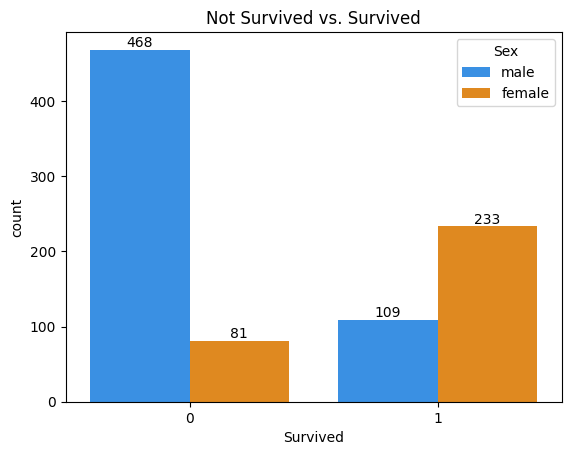

In [51]:
# Examining the survival rates of our passengers with consideration to their gender

colors = {'male': 'dodgerblue', 'female': 'darkorange', 'child': 'forestgreen'}

ax = sns.countplot(data=titanic_df, x='Survived', hue='Sex', palette=colors)
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
plt.title('Not Survived vs. Survived')

We see that many more men died than women. Perhaps it has to do with the famous words from the movie "Titanic": "Women and children first." We will now modify the data a bit by adding new information about sex - if the age is less than or equal to 16 years, the passenger will be considered a child.

In [52]:
def child(age, sex):
    if age <= 16:
        return 'child'
    else:
        return sex
    
titanic_df['Sex'] = titanic_df[['Age', 'Sex']].apply(lambda x: child(x['Age'], x['Sex']), axis=1)

Text(0.5, 1.0, 'Not Survived vs. Survived')

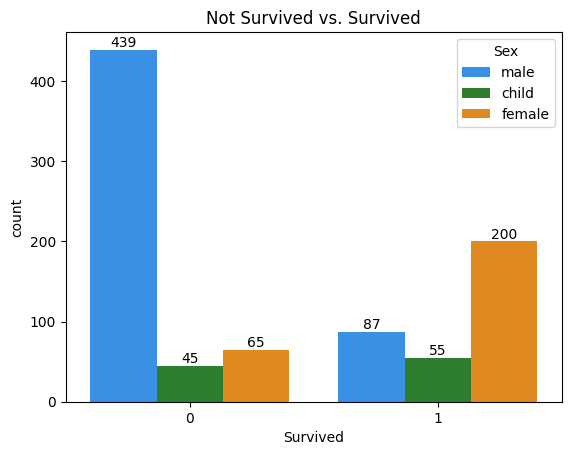

In [53]:
# Re-Examining the survival rates of our passengers with consideration to their gender
ax = sns.countplot(data=titanic_df, x='Survived', hue='Sex', palette=colors)
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
ax.bar_label(container=ax.containers[2])
plt.title('Not Survived vs. Survived')


It's apparent that only a slightly higher number of children survived compared to those who perished. The most significant distinction in survival based on gender is observed primarily within the male group.

Now, let's analyze the survival probabilities based on the ticket class.

Text(0, 0.5, 'Chances of Survival')

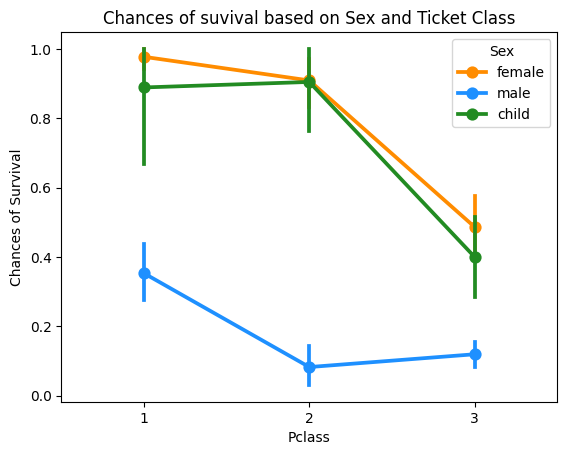

In [57]:
sns.pointplot(data=titanic_df, x='Pclass', y='Survived', hue='Sex', palette=colors)
plt.title('Chances of suvival based on Sex and Ticket Class')
plt.ylabel('Chances of Survival')

The error bar represents the 95% Confidence Interval, calculated around the mean to provide an estimate of the range within which the population mean is likely to fall. Seaborn employs the bootstrap method for computing this Confidence Interval. Once again, it is evident that males had the lowest chances of survival. According to the chart, females have the highest likelihood of survival. Nevertheless, it is noticeable that if a woman or a child had a 3rd-class ticket, their chances of survival significantly decreased. In summary, we can assert that gender significantly influences the chances of survival.

Now, let's explore the ticket prices paid by our passengers.

Text(0.5, 1.0, 'Distribution of passangers ticket price')

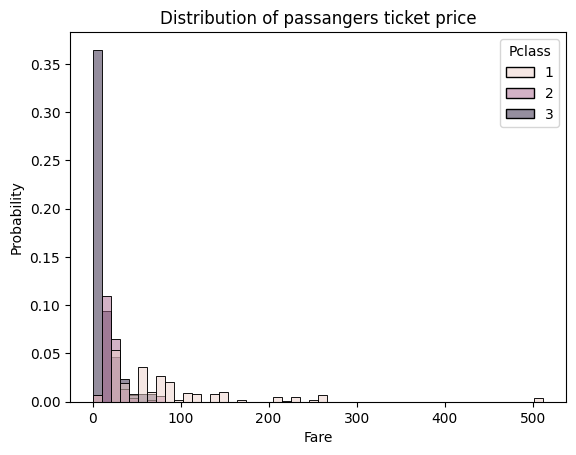

In [56]:
sns.histplot(data=titanic_df, x='Fare', hue='Pclass', bins=50, stat='probability')
plt.title('Distribution of passangers ticket price')

We can observe that the majority of our passengers paid less than 100, and a significant portion held third-class tickets. Building on insights from previous charts, it's noteworthy that for passengers who were not male, third-class tickets were associated with decreased chances of survival. Additionally, there appears to be a notable price gap between 250 and 510, indicating potential outliers. To identify these outliers, we can employ the Z-score method. The Z-Score is calculated as: 
$$ 
    Z=\frac{X - μ}{S},
$$
where X is a specific observation in our dataset, μ is the mean of our variable and S is the standard deviation. If the Z-Score is greater than 3 or less than -3, the observation is considered an outlier. Let's delve deeper into our data related to fare using this approach.

In [58]:
mean = titanic_df['Fare'].mean()
deviation = titanic_df['Fare'].std()
titanic_df['Z_Score'] = ['Outlier' if (x-mean)/deviation > 3 or (x-mean)/deviation < -3 else "Standard Observation" for x in titanic_df['Fare']]
titanic_df[titanic_df['Z_Score'] == 'Outlier']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Z_Score
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263.0000,S,Outlier
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23,3,2,19950,263.0000,S,Outlier
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24,0,1,PC 17558,247.5208,C,Outlier
258,259,1,1,"Ward, Miss. Anna",female,35,0,0,PC 17755,512.3292,C,Outlier
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50,0,1,PC 17558,247.5208,C,Outlier
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18,2,2,PC 17608,262.3750,C,Outlier
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24,3,2,19950,263.0000,S,Outlier
377,378,0,1,"Widener, Mr. Harry Elkins",male,27,0,2,113503,211.5000,C,Outlier
380,381,1,1,"Bidois, Miss. Rosalie",female,42,0,0,PC 17757,227.5250,C,Outlier
438,439,0,1,"Fortune, Mr. Mark",male,64,1,4,19950,263.0000,S,Outlier


We observe that 20 entries in our dataset are classified as outliers, and interestingly, all of them pertain to passengers with first-class tickets. While these outliers might present challenges in the future, we've decided to keep them unchanged for now.

Our next point of analysis is to explore the relationship between age and the probability of survival.

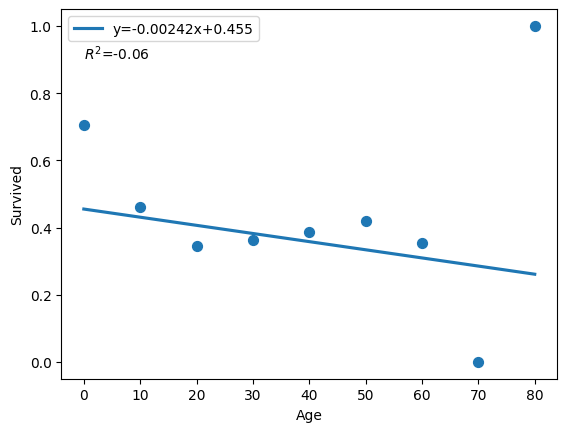

In [70]:
age_bins = list(range(0,100,10))
slope, intercept, r_value, p_value, std_err = stats.linregress(x=titanic_df['Age'], y=titanic_df['Survived'])

ax = sns.regplot(data=titanic_df, x='Age', y='Survived', x_bins=age_bins, ci=None,
    line_kws = {'label':'y={0:.5f}x+{1:.3f}'.format(slope,intercept)})
plt.text(0,0.9,f'$R^2$={round(r_value,2)}')
ax.legend()
plt.show()

We can observe that the survival rates tend to decrease as individuals get older. Let's now examine how this association looks when we take into account the variable of gender.

c:\Users\mpoza\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


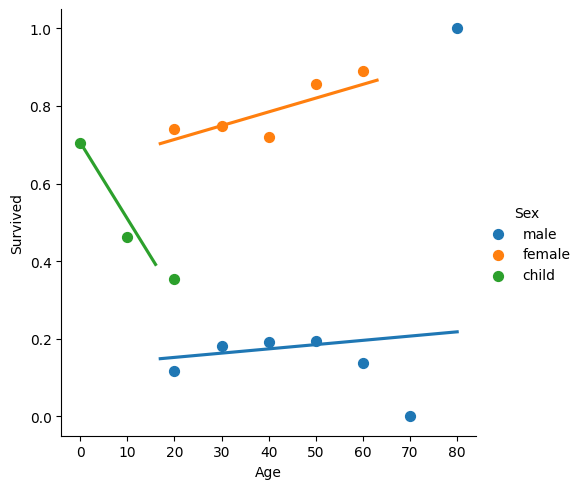

In [83]:
sns.lmplot(data=titanic_df, x='Age', y='Survived', x_bins=age_bins, hue='Sex', ci=None)

Young men, specifically those aged 20 or younger, had the lowest probability of surviving the shipwreck. However, within both the male and female groups, as individuals grew older, their chances of survival increased. A noteworthy observation is that the oldest passenger, an 80-year-old man, managed to survive the crash.

Shifting our focus, we can now explore the number of passengers who were traveling alone versus those accompanied by someone else.

In [84]:
def alone(sib, parch):
    if sib + parch == 0:
        return 'Alone'
    else:
        return 'With Someone'
    
titanic_df['Alone'] = titanic_df[['SibSp', 'Parch']].apply(lambda x: alone(x['SibSp'], x['Parch']), axis=1)
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Z_Score,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Standard Observation,With Someone
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Standard Observation,With Someone
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Standard Observation,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Standard Observation,With Someone
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Standard Observation,Alone


Text(0.5, 1.0, 'Comparing solo travelers and those accompanied')

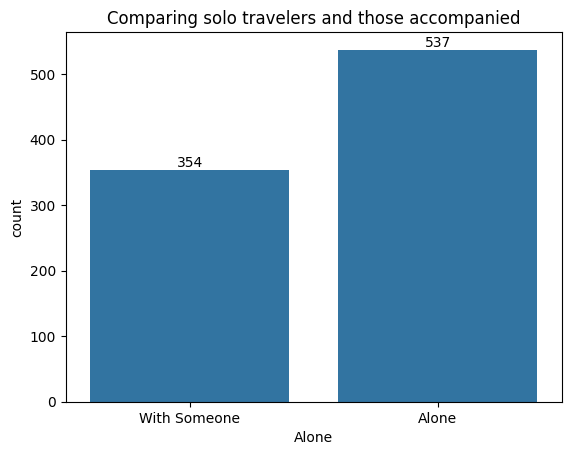

In [92]:
ax = sns.countplot(data=titanic_df, x='Alone')
ax.bar_label(container=ax.containers[0])
plt.title('Comparing solo travelers and those accompanied')

The majority of our passengers were solo travelers. Now, let's examine whether having a companion affects the chances of survival.

Text(0.5, 1.0, 'Chances of surviving alone vs. with a companion')

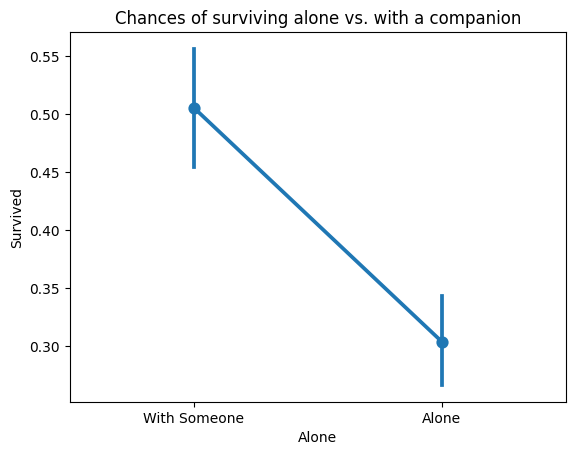

In [93]:
sns.pointplot(data=titanic_df, x='Alone', y='Survived')
plt.title('Chances of surviving alone vs. with a companion')

It can be concluded that traveling with a companion significantly increases the likelihood of survival. As we conclude the Exploratory Data Analysis process, the final step is to assess the correlation between our variables.

Text(0.5, 1.0, 'Pearson correlation between our variables')

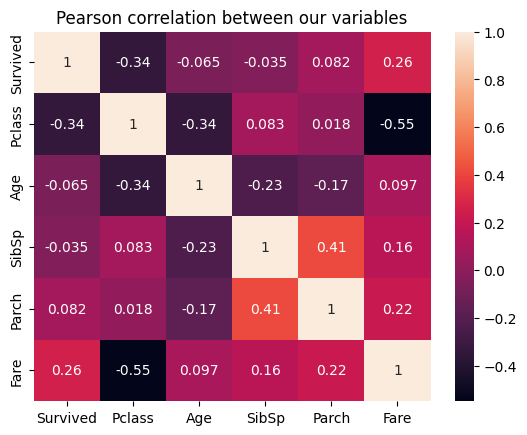

In [98]:
sns.heatmap(titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Sex', 'Z_Score', 'Alone'], axis=1).corr(), annot=True)
plt.title('Pearson correlation between our variables')

The most significant correlation is observed between 'Fare' and 'Pclass'. This means that the higher the price you pay for your ticket, the better class you will be assigned, which is as expected. Additionally, there is a noticeable correlation between 'Pclass' and 'Survived' variables. This means that having a first class ticket is associated with an increased probability of survival.

### Machine Learning

#### Dummy model
In order to assess the performance of our model, we will employ a Dummy model as a benchmark. The Dummy model serves as a baseline, helping us determine if our actual model performs better than random chance. Unlike our true model, the Dummy model relies on basic probability measurements and does not utilize any specific features. We will employ the stratified method, where the predictor randomly generates one-hot vectors from a multinomial distribution based on the empirical class prior probabilities. Before building our models, we will create dummy variables and remove unnecessary features

In [99]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Z_Score', 'SibSp', 'Parch', 'Ticket'], axis=1)
titanic_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone
0,0,3,male,22,7.2500,S,With Someone
1,1,1,female,38,71.2833,C,With Someone
2,1,3,female,26,7.9250,S,Alone
3,1,1,female,35,53.1000,S,With Someone
4,0,3,male,35,8.0500,S,Alone


              precision    recall  f1-score   support

           0       0.70      0.67      0.69       167
           1       0.49      0.52      0.51       101

    accuracy                           0.62       268
   macro avg       0.60      0.60      0.60       268
weighted avg       0.62      0.62      0.62       268

The overall precision score of our model is 0.49


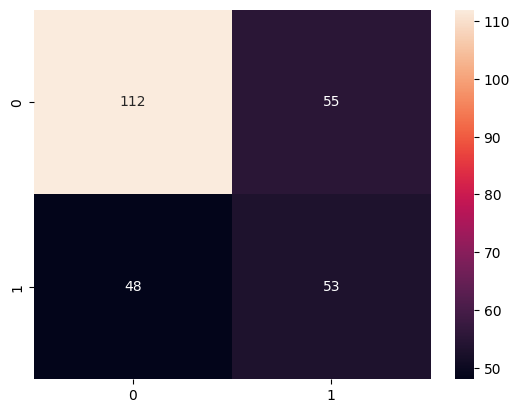

In [116]:
# Building the model
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)

dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)
print(classification_report(y_test, dummy_predictions))
sns.heatmap(confusion_matrix(y_test, dummy_predictions), annot=True, fmt='g')
print(f'The overall precision score of our model is {round(precision_score(y_test, dummy_predictions),2)}')

The accuracy of guessing the Survived class correctly based solely on random guessing can be calculated using the following equation:
$$
    \frac{TP + TN}{TP + FP + FN + TN}
$$

#### Logistic Regression
In this phase, we will construct models using the Logistic Regression algorithm. Beforehand, it is necessary to generate dummy variables to represent our non-numeric variables in a numerical format.

The mean accuracy on train set is queal to: 0.81
The mean accuracy on test set is queal to: 0.78
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       178
           1       0.64      0.79      0.71        90

    accuracy                           0.78       268
   macro avg       0.76      0.78      0.77       268
weighted avg       0.80      0.78      0.78       268



Text(0.5, 1.0, 'Feature Importance Plot')

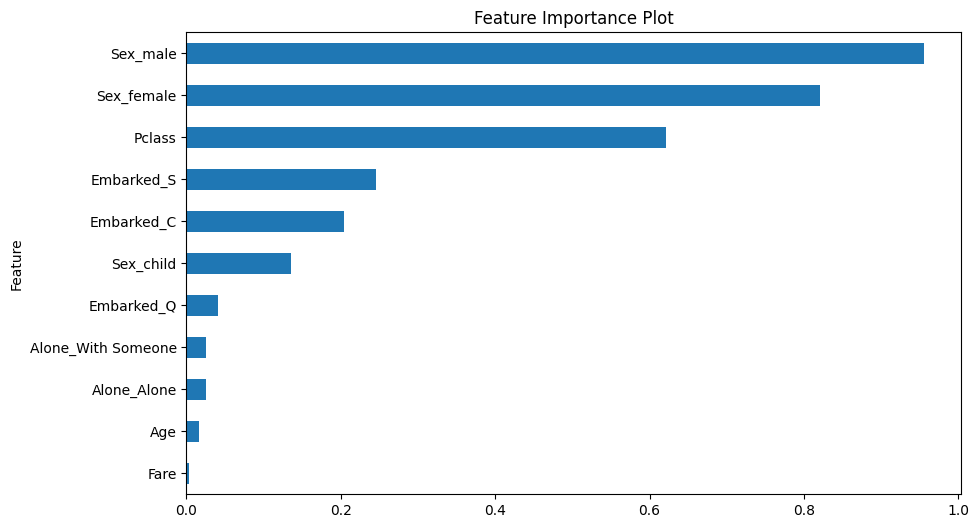

In [138]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_model = LogisticRegressionCV(max_iter=1000)
log_model.fit(X_train, y_train)
log_model_predictions = log_model.predict(X_test)
print(f'The mean accuracy on train set is queal to: {round(log_model.score(X_train, y_train),2)}')
print(f'The mean accuracy on test set is queal to: {round(log_model.score(X_test, y_test),2)}')
print(classification_report(log_model_predictions, y_test))

coefficients = log_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10,6), legend=False)
plt.title('Feature Importance Plot')

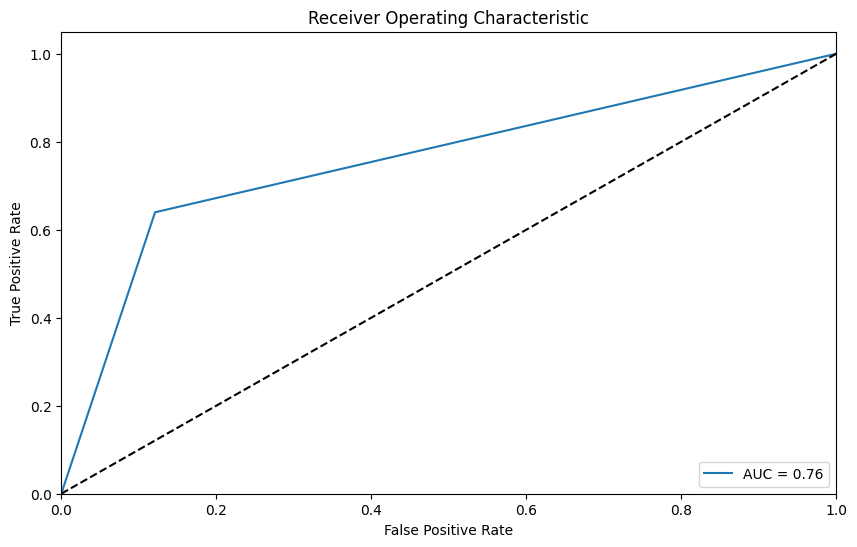

In [139]:
fpr, tpr, thresholds = roc_curve(y_test, log_model_predictions)
roc_auc = roc_auc_score(y_test, log_model_predictions)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

We observe that a simple logistic regression yields significantly better results than random guessing. Assessing accuracy on both test and training data reveals no signs of overfitting or underfitting. The relationship between False Positive Rate and True Positive Rate is reasonably favorable, indicated by an Area Under the Curve (AUC) value of 0.76. Overall, our model demonstrates effectiveness in uncovering data relationships and generalizing to unseen data. However, the variable 'Fare' appears to hold minimal importance in model construction. To enhance the model further, we will explore GridSearch to identify optimal parameters, considering penalties such as L1 and L2 on large weights. Additionally, we will investigate the best regularization approach for our features.

In [140]:
# GridSearch
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
params = {'Cs': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
model = LogisticRegressionCV(max_iter=10000, solver='liblinear')
grid_search = GridSearchCV(model, params, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
print(f'The best parameters for this model are {grid_search.best_params_}')
print(f'The best score for this model is equal to {grid_search.best_score_}')

c:\Users\mpoza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mpoza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mpoza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\mpoza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py

The best parameters for this model are {'Cs': 100, 'penalty': 'l2'}
The best score for this model is equal to 0.6930272108843538


The mean accuracy on train set is queal to: 0.82
The mean accuracy on test set is queal to: 0.8
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       164
           1       0.75      0.73      0.74       104

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



Text(0.5, 1.0, 'Feature Importance Plot v2')

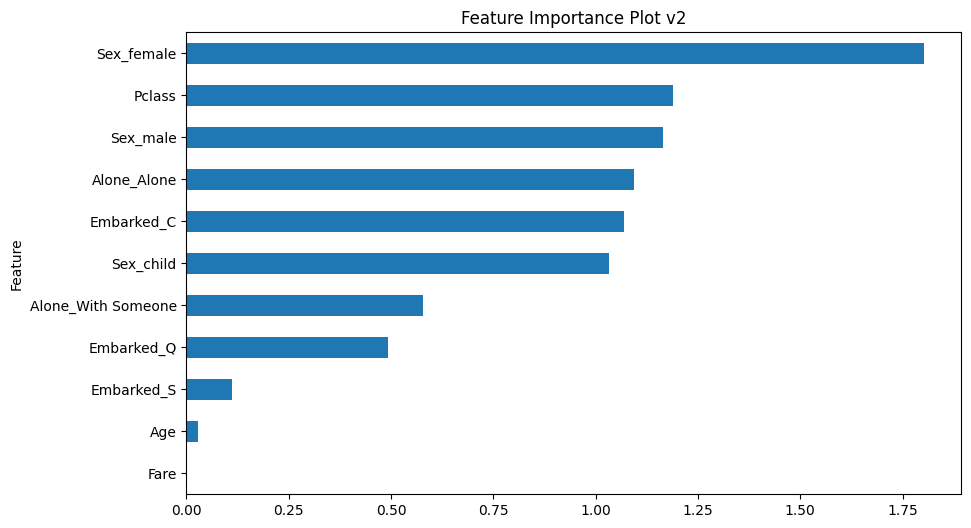

In [141]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)

log_model = LogisticRegressionCV(max_iter=10000, solver='liblinear', Cs=100, penalty='l2')
log_model.fit(X_train, y_train)
log_model_predictions = log_model.predict(X_test)
print(f'The mean accuracy on train set is queal to: {round(log_model.score(X_train, y_train),2)}')
print(f'The mean accuracy on test set is queal to: {round(log_model.score(X_test, y_test),2)}')
print(classification_report(log_model_predictions, y_test))

coefficients = log_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10,6), legend=False)
plt.title('Feature Importance Plot v2')

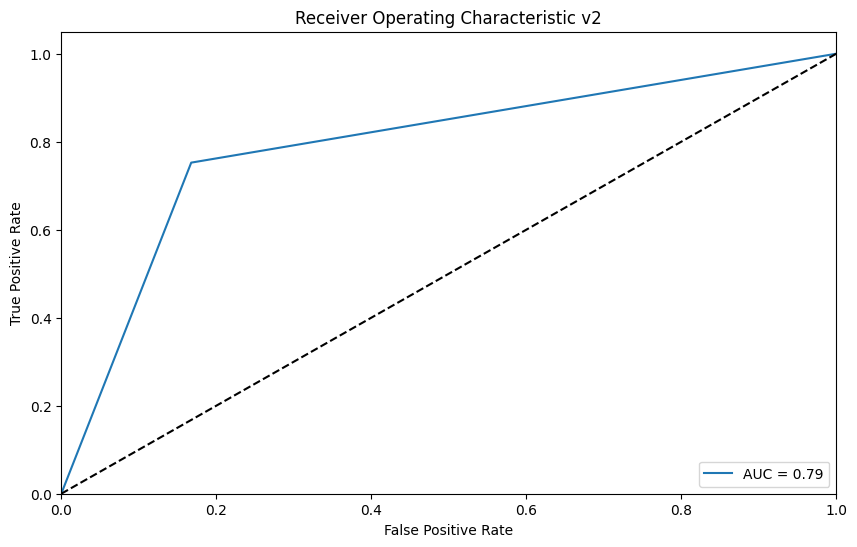

In [142]:
fpr, tpr, thresholds = roc_curve(y_test, log_model_predictions)
roc_auc = roc_auc_score(y_test, log_model_predictions)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic v2')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix following the adjustment of the hyperparameter')

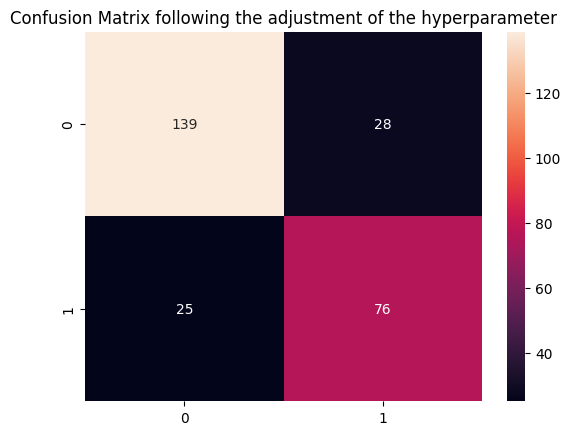

In [145]:
sns.heatmap(confusion_matrix(y_test, log_model_predictions), fmt='g', annot=True)
plt.title('Confusion Matrix following the adjustment of the hyperparameter')

Following the adjustment of parameters, there is a slight improvement in the accuracy score. Precision scores have also shown slight improvement in both groups, although there is a slight decrease in the recall score for group 1. The AUC has marginally improved, but the overall enhancement is not significant. In summary, it can be concluded that the model after hyperparameter tuning is an improvement over the simple logistic regression. However, it appears that logistic regression may not capture all the relationships within the dataset. Next, we will assess whether a Random Forest model can address this issue.

#### Random Forest
As observed previously, logistic regression may not be the optimal choice for predicting the survivors of the Titanic crash. To explore this issue, we can examine whether a decision tree model is more effective. However, a single decision tree poses a significant challenge, namely a tendency to overfit. To address this concern, we will attempt to mitigate overfitting by employing an ensemble of decision trees.

In [148]:
random_forest = RandomForestClassifier()
X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
random_forest.fit(X_train, y_train)
random_forest_predicitons = random_forest.predict(X_test)
print(f'Random forest train score is equal to: {round(random_forest.score(X_train, y_train),2)}')
print(f'Random forest test score is equal to: {round(random_forest.score(X_test, y_test),2)}')

Random forest train score is equal to: 0.98
Random forest test score is equal to: 0.83


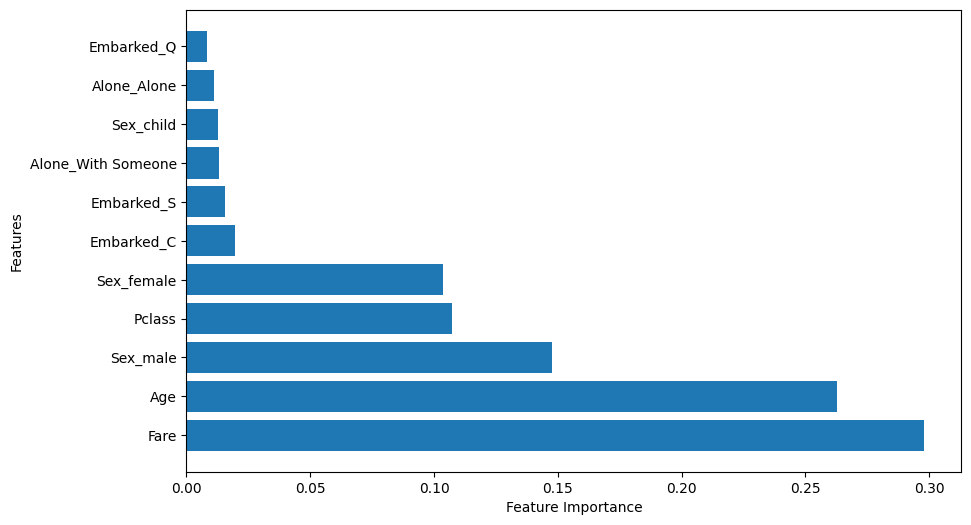

In [149]:
plt.figure(figsize=(10,6))
sorted_indices = np.argsort(random_forest.feature_importances_)
sorted_values = random_forest.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

We observe an interesting discrepancy. The importance of features differs significantly compared to the logistic regression model. In the previous model, Fare had almost zero importance, while in the Random Forest, it emerges as the most crucial feature. Additionally, the model's performance on the training set is notably superior to that on the test set, suggesting a potential issue of overfitting.

To further investigate, we will conduct a Cross-Validation test to assess the generalization performance of our model.

In [160]:
random_forest = RandomForestClassifier()
cv_score = cross_val_score(random_forest, X, y, cv=10)
print('Cross-validation scores on train set (10-fold): ', cv_score)
print('Mean cross-validation score on train set (10-fold): {:.4f}'.format(np.mean(cv_score)))

Cross-validation scores on train set (10-fold):  [0.74444444 0.85393258 0.76404494 0.82022472 0.88764045 0.80898876
 0.83146067 0.76404494 0.79775281 0.82022472]
Mean cross-validation score on train set (10-fold): 0.8093


Text(0, 0.5, 'CV score')

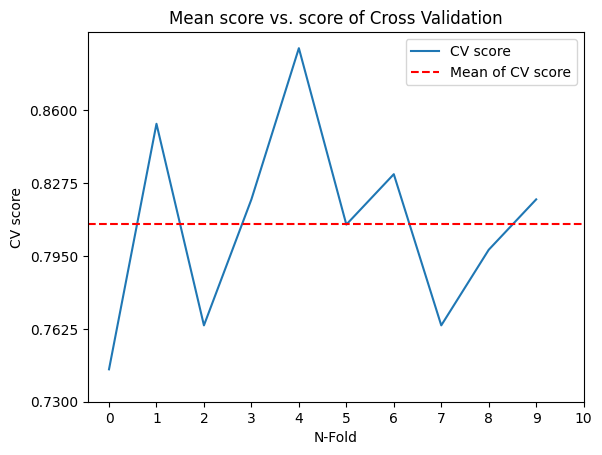

In [161]:
plt.plot(cv_score, label='CV score')
plt.xticks(range(0,11))
plt.yticks(np.linspace(0.73,0.86,5))
plt.axhline(np.mean(cv_score), color='r', linestyle='dashed', label='Mean of CV score')
plt.legend()
plt.title('Mean score vs. score of Cross Validation')
plt.xlabel('N-Fold')
plt.ylabel('CV score')

The chart presented indicates that the model's score is expected to be approximately 0,81. Nevertheless, there is a notable range between the minimum and maximum scores, spanning around 0,13. This suggests that various combinations of our data can indeed lead to significant variations in the model's performance.

<Axes: >

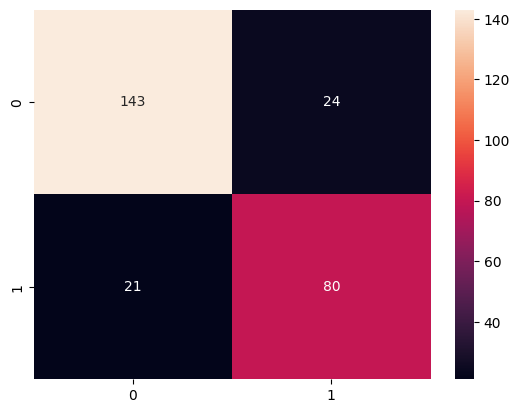

In [162]:
sns.heatmap(confusion_matrix(y_test, random_forest_predicitons), fmt='g', annot=True)

Overall, it can be concluded that the simple Random Forest model outperformed the logistic regression. The occurrence of both False Positives and False Negatives is lower. Now, let's examine the ROC Curve.

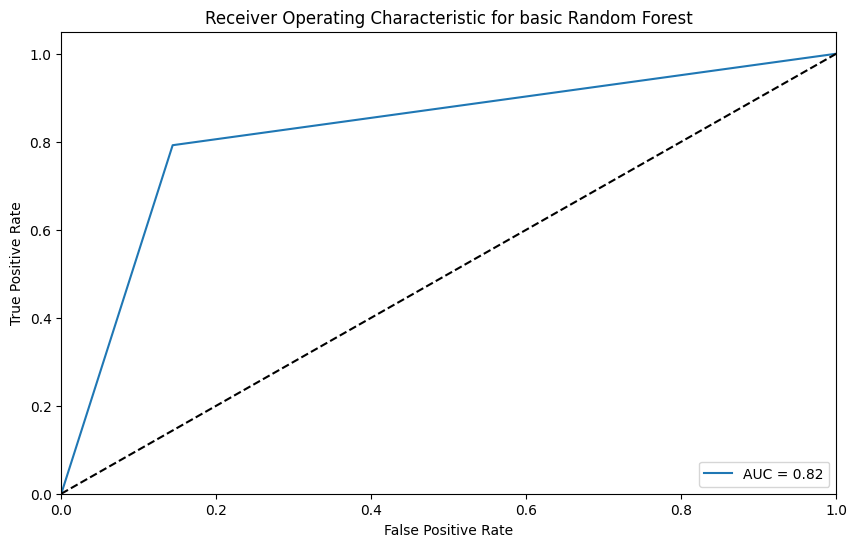

In [164]:
fpr, tpr, thresholds = roc_curve(y_test, random_forest_predicitons)
roc_auc = roc_auc_score(y_test, random_forest_predicitons)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for basic Random Forest')
plt.legend(loc='lower right')
plt.show()

The AUC score is superior compared to logistic regression. Nevertheless, let's explore whether further improvements are achievable. The primary challenge in tree-type models lies in their depth, a major factor contributing to overfitting, as each tree tends to classify every record. We will conduct a grid search to address this issue and optimize the model.

In [165]:
random_forest_grid = RandomForestClassifier()
X = titanic_df_dummy.drop('Survived',axis=1)
y = titanic_df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
params_random_forest = {'n_estimators':[50, 100, 150, 200],'max_depth':[2, 3, 4]}
grid_search_random = GridSearchCV(random_forest_grid, params_random_forest,scoring='accuracy')
grid_search_random.fit(X_train,y_train)
print(f'The best parameters for Random Forest are: {grid_search_random.best_params_}')
print(f'The best score for best parameters is equal to: {grid_search_random.best_score_}')

The best parameters for Random Forest are: {'max_depth': 4, 'n_estimators': 150}
The best score for best parameters is equal to: 0.8154193548387096


In [166]:
random_forest_best = RandomForestClassifier(n_estimators=150, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
random_forest_best.fit(X_train, y_train)
random_forest_best_predictions = random_forest_best.predict(X_test)
print(f'Score on training set is equal to: {round(random_forest_best.score(X_train, y_train), 2)}')
print(f'Score on testing data is equal to: {round(random_forest_best.score(X_test, y_test), 2)}')
print(classification_report(y_test, random_forest_best_predictions))

Score on training set is equal to: 0.84
Score on testing data is equal to: 0.82
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       167
           1       0.80      0.69      0.74       101

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



<Axes: >

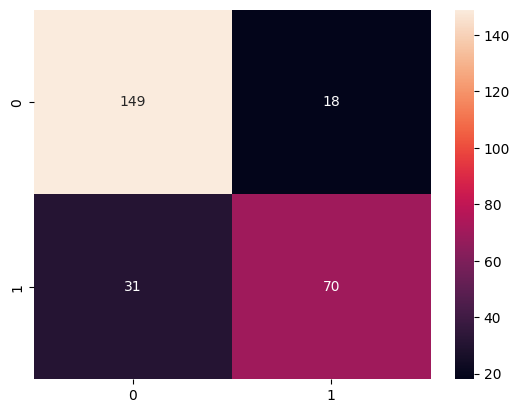

In [167]:
sns.heatmap(confusion_matrix(y_test, random_forest_best_predictions), fmt='g', annot=True)

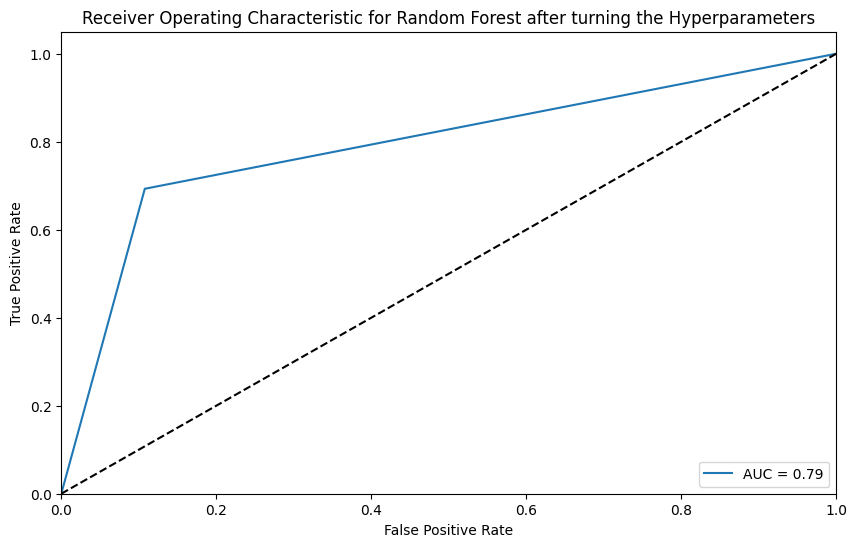

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, random_forest_best_predictions)
roc_auc = roc_auc_score(y_test, random_forest_best_predictions)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest after turning the Hyperparameters')
plt.legend(loc='lower right')
plt.show()

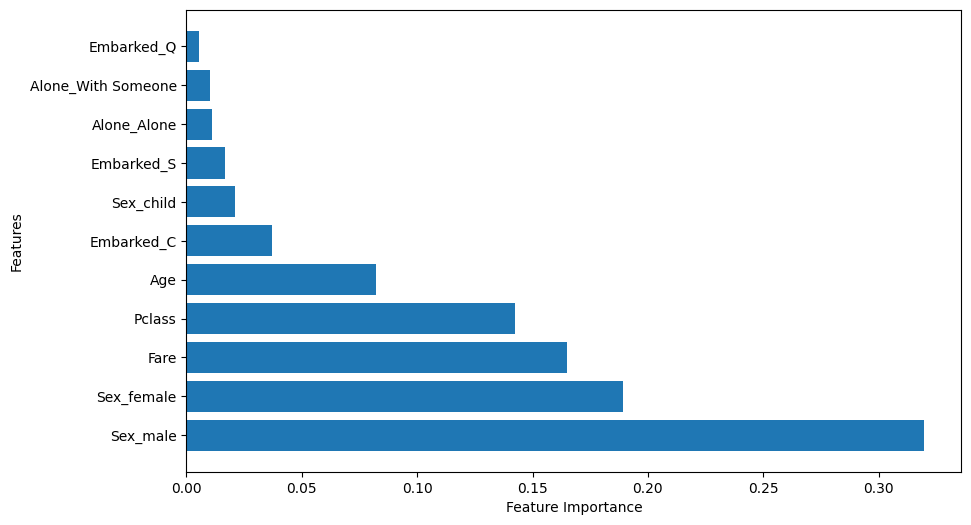

In [169]:
plt.figure(figsize=(10,6))
sorted_indices = np.argsort(random_forest_best.feature_importances_)
sorted_values = random_forest_best.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

Adjusting the hyperparameters helped mitigate the substantial difference between scores on the test and training sets, although it came with certain trade-offs. While we managed to reduce False Positives, there was an increase in False Negatives. The AUC curve value has slightly decreased. Upon inspecting the feature importances of the tuned Random Forest Model, it is evident that the variable 'Sex_male' now rightfully holds the top position, aligning with our Exploratory Data Analysis. However, the features 'Fare' and 'Age' still retain relatively high positions in the hierarchy.

#### Gradeint Boosting
In recent times, gradient-based reinforcement learning models have become increasingly popular due to their consistent high-performance metrics in model evaluation. This approach leverages both weak and strong learners. Essentially, the model assigns higher weights to entries where predictions are incorrect. Subsequent weak learner models are trained on these adjusted weights, and this iterative process is repeated multiple times until a specified stopping criterion is reached. The final prediction is determined through a majority vote, combining the predictions of all the weak models.

In [171]:
titanic_df_dummy = pd.get_dummies(titanic_df)

X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=102)

gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train,y_train)
gradient_predictions = gradient_model.predict(X_test)
print(f'The accuracy score on training dataset is equal to: {round(gradient_model.score(X_train, y_train), 2)}')
print(f'The accuracy on the test dataset is equal to: {round(gradient_model.score(X_test, y_test), 2)}')
print(classification_report(y_test, gradient_predictions))

The accuracy score on training dataset is equal to: 0.91
The accuracy on the test dataset is equal to: 0.82
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       167
           1       0.78      0.73      0.76       101

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



<Axes: >

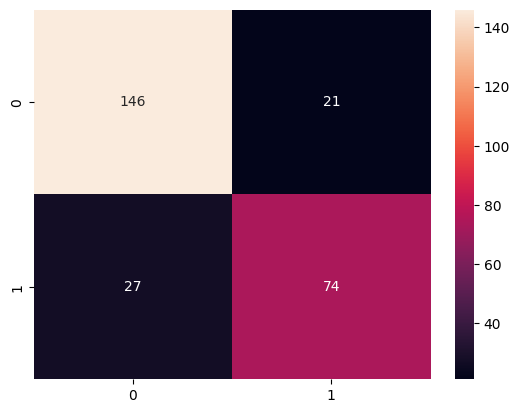

In [172]:
sns.heatmap(confusion_matrix(y_test, gradient_predictions), annot=True, fmt='g')

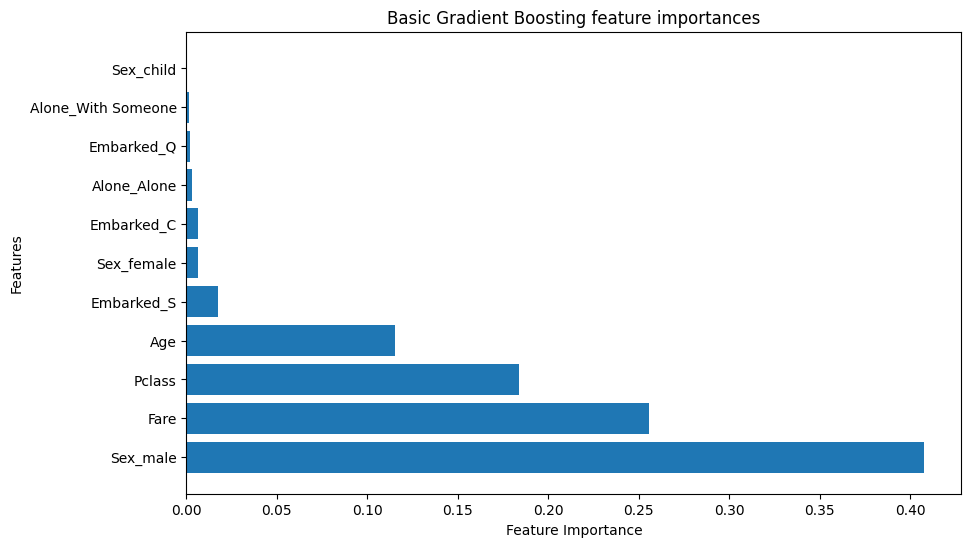

In [173]:
plt.figure(figsize=(10,6))
sorted_indices = np.argsort(gradient_model.feature_importances_)
sorted_values = gradient_model.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Basic Gradient Boosting feature importances')
plt.show()

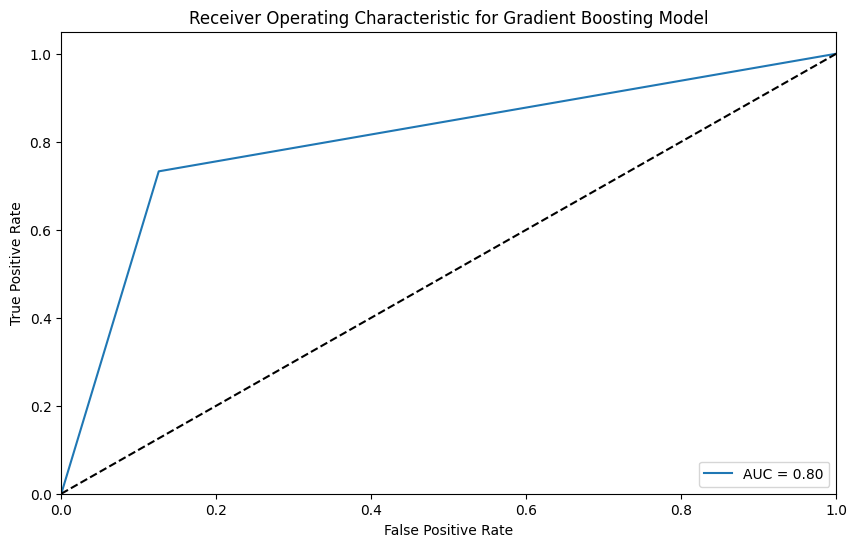

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, gradient_predictions)
roc_auc = roc_auc_score(y_test, gradient_predictions)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Gradient Boosting Model')
plt.legend(loc='lower right')
plt.show()

The overall performance of the model closely resembles that of the random forest model. While our ROC value aligns with the Random Forest model, there is an increase in both False Positives and False Negatives. To address this, we can initiate a grid search to explore and discover optimal parameters for further improvement.

In [175]:
params = {'loss':['log_loss','exponential'],
          'learning_rate':[0.01, 0.05, 0.1],
          'n_estimators':[100, 150, 200, 250, 300, 350],
          'max_depth':[3, 4, 5],
          'max_leaf_nodes':[10, 15, 20]}

gradient_model = GradientBoostingClassifier()
X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
grid_search_boost = GridSearchCV(gradient_model, params, cv=5, scoring='accuracy')
grid_search_boost.fit(X_train, y_train)
print(f"The best parameters of the Gradient Boosting Model are: {grid_search_boost.best_params_}")
print(f"The best accuracy we can get is: {grid_search_boost.best_score_}")

The best parameters of the Gradient Boosting Model are: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 3, 'max_leaf_nodes': 10, 'n_estimators': 200}
The best accuracy we can get is: 0.8314709677419355


In [176]:
X = titanic_df_dummy.drop('Survived', axis=1)
y = titanic_df_dummy['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)
gradient_best_model = GradientBoostingClassifier(loss='exponential',
                                                 learning_rate=0.01,
                                                 n_estimators=200,
                                                 max_depth=3,
                                                 max_leaf_nodes=10)
gradient_best_model.fit(X_train, y_train)
gradient_best_predictions = gradient_best_model.predict(X_test)
print(f'The accuracy score on training dataset is equal to: {round(gradient_best_model.score(X_train, y_train), 2)}')
print(f'The accuracy on the test dataset is equal to: {round(gradient_best_model.score(X_test,y_test), 2)}')
print(classification_report(y_test, gradient_best_predictions))

The accuracy score on training dataset is equal to: 0.84
The accuracy on the test dataset is equal to: 0.82
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       167
           1       0.79      0.70      0.74       101

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



<Axes: >

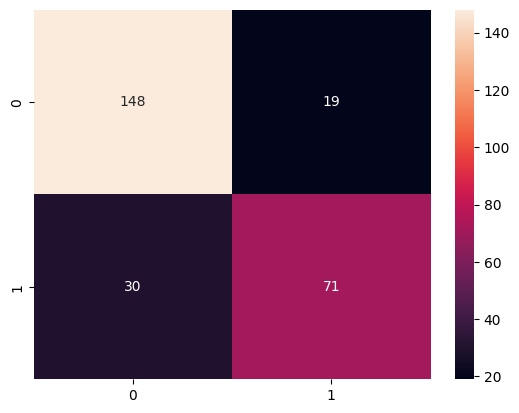

In [177]:
sns.heatmap(confusion_matrix(y_test, gradient_best_predictions), annot=True, fmt='g')

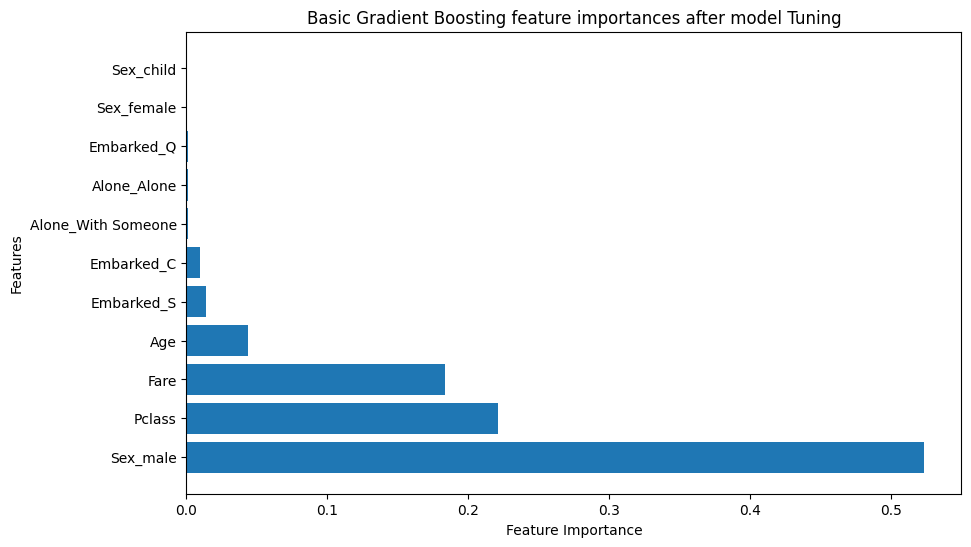

In [178]:
plt.figure(figsize=(10,6))
sorted_indices = np.argsort(gradient_best_model.feature_importances_)
sorted_values = gradient_best_model.feature_importances_[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.barh(sorted_columns, sorted_values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Basic Gradient Boosting feature importances after model Tuning')
plt.show()

Observing the outcomes, it is evident that the Gradient Boosting model exhibited slightly inferior performance compared to the Random Forest. While gradient boosting models are currently among the most favored, it's crucial to note that their performance may not consistently surpass that of other models.

In summary, when considering accuracy, models such as Random Forest and Gradient Boosting demonstrated the most favorable results, achieving an accuracy of 82%. Nonetheless, there remains potential for enhancement, such as addressing outliers, modifying features across various models, or exploring numerous other avenues for improvement.